In [1]:
from paths import *
%matplotlib inline

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.io import loadmat
import numpy as np
import h5py
import pandas
import scipy
from scipy.ndimage.interpolation import zoom
from skimage import measure
import SimpleITK as sitk
from scipy.ndimage.morphology import binary_dilation,generate_binary_structure
from skimage.morphology import convex_hull_image
import pandas
from multiprocessing import Pool
from functools import partial
import sys
from joblib import Parallel, delayed
import warnings

In [51]:
def load_train(PATH):
    src = PATH['src']
    data_path = src
    folders = [x for x in os.listdir(data_path) if 'subset' in x]
    os.chdir(data_path)
    patients = []
    for i in folders:
        os.chdir(data_path + i)
        # print('Changing folder to: {}'.format(data_path + i))
        patient_ids = [x for x in os.listdir(data_path + i) if '.mhd' in x]
        for id in patient_ids:
            j = '{}/{}'.format(i, id)
            patients.append(j)
    return patients

def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return (f)

def resample(imgs, spacing, new_spacing,order=2):
    if len(imgs.shape)==3:
        new_shape = np.round(imgs.shape * spacing / new_spacing)
        true_spacing = spacing * imgs.shape / new_shape
        resize_factor = new_shape / imgs.shape
        imgs = zoom(imgs, resize_factor, mode = 'nearest',order=order)
        return imgs, true_spacing
    elif len(imgs.shape)==4:
        n = imgs.shape[-1]
        newimg = []
        for i in range(n):
            slice = imgs[:,:,:,i]
            newslice,true_spacing = resample(slice,spacing,new_spacing)
            newimg.append(newslice)
        newimg=np.transpose(np.array(newimg),[1,2,3,0])
        return newimg,true_spacing
    else:
        raise ValueError('wrong shape')
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def load_itk_image(filename):
    with open(filename) as f:
        contents = f.readlines()
        line = [k for k in contents if k.startswith('TransformMatrix')][0]
        transformM = np.array(line.split(' = ')[1].split(' ')).astype('float')
        transformM = np.round(transformM)
        if np.any( transformM!=np.array([1,0,0, 0, 1, 0, 0, 0, 1])):
            isflip = True
        else:
            isflip = False

    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing,isflip

def process_mask(mask):
    convex_mask = np.copy(mask)
    for i_layer in range(convex_mask.shape[0]):
        mask1  = np.ascontiguousarray(mask[i_layer])
        if np.sum(mask1)>0:
            mask2 = convex_hull_image(mask1)
            if np.sum(mask2)>1.5*np.sum(mask1):
                mask2 = mask1
        else:
            mask2 = mask1
        convex_mask[i_layer] = mask2
    struct = generate_binary_structure(3,1)  
    dilatedMask = binary_dilation(convex_mask,structure=struct,iterations=10) 
    return dilatedMask


def lumTrans(img):
    lungwin = np.array([-1200.,600.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
    newimg[newimg<0]=0
    newimg[newimg>1]=1
    newimg = (newimg*255).astype('uint8')
    return newimg

def draw_nodule_mask(label2,image_mask):
    coord_x = label2[0]
    coord_y = label2[1]
    coord_z = label2[2]
    diam = label2[3]
    radius = np.ceil(diam / 2)
    noduleRange = seq(-radius, radius, 1)
    voxel_center = np.array((coord_x, coord_y, coord_z))
    for x in noduleRange:
        for y in noduleRange:
            for z in noduleRange:
                coords = np.array((coord_z + z, coord_y + y, coord_x + x))
                if (np.linalg.norm(voxel_center - coords) * 1) < radius:
                    image_mask[int(np.round(coords[0])), int(np.round(coords[1])), int(np.round(coords[2]))] = int(1)
        return image_mask

def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])
    
def cut_sample(aa,bb,label2,patient_id):
    aa = np.squeeze(aa)
    bb = np.squeeze(bb)
    coord_x = label2[0]
    coord_y = label2[1]
    coord_z = label2[2]
    diam = label2[3]
    radius = np.ceil(diam/2)
    for i in range(int(diam // 7) + 1):
        a0, b0 = general128_sample3d(aa, bb, radius, coord_x, coord_y, coord_z)

        np.save(savepath + str('lung_') + str('rand_') + str(patient_id) + str('_') + str(int(coord_x)).zfill(4)
                    + str('_') + str(i).zfill(2) + '.npy', a0)

        np.save(savepath + str('mask_') + str(patient_id) + str('_') + str(int(coord_x)).zfill(4)
                    + str('_') + str(i).zfill(2) + '.npy', b0)

    ww, vv, uu = rand_neg(aa, radius, coord_x, coord_y, coord_z)
    c0, d0 = general128_sample3d(aa, bb, radius, ww, vv, uu)
    np.save(savepath + str('lung_') + str(patient_id) + '.npy', c0)
    np.save(savepath + str('mask_') + str(patient_id) + '.npy', d0)
    return

def general128_sample3d(aaa,bbb,radius,coord_x, coord_y, coord_z):
    rand_num = np.random.randint(-15, 15, size=(1,3))
    x1 = np.maximum(int(coord_x + radius - 64- rand_num[0][0]),0)  
    y1 = np.maximum(int(coord_y + radius - rand_num[0][1]),0)
    z1 = np.maximum(int(coord_z + radius - rand_num[0][2]),0)
       
    x_ = x1 + 128
    y_ = y1 + 128
    z_ = z1 + 128

    x2 = np.minimum(x_,aaa.shape[0])
    y2 = np.minimum(y_,512)
    z2 = np.minimum(z_,512)
    
    sample1 = np.zeros([128, 128, 128])
    sample2 = np.zeros([128, 128, 128])
    ccx = x2-x1
    ccy = y2-y1
    ccz = z2-z1
    
    ccc1 = aaa.shape[0] - np.maximum(aaa.shape[0]-128,0)  
    
    if ccx == 0:
        sample1[0:ccc1, 0:y2-y1, 0:z2-z1] = aaa[np.maximum(aaa.shape[0]-128,0):aaa.shape[0], y1:y2, z1:z2]
        sample2[0:ccc1, 0:y2-y1, 0:z2-z1] = bbb[np.maximum(aaa.shape[0]-128,0):aaa.shape[0], y1:y2, z1:z2]
    else:
        sample1[0:ccx, 0:ccy, 0:ccz] = aaa[x1:x2, y1:y2, z1:z2]
        sample2[0:ccx, 0:ccy, 0:ccz] = bbb[x1:x2, y1:y2, z1:z2]
    return sample1,sample2

def rand_neg(aa,radius,coord_x, coord_y, coord_z):
    z1, z2 = int(coord_z  - radius), int(coord_z  + radius)
    y1, y2 = int(coord_y  - radius), int(coord_y  + radius)
    x1, x2 = int(coord_x  - radius), int(coord_x  + radius)

    for u in np.random.randint(80, aa.shape[2] - 80, size=32):
        if u > z2 or u < z1:
            uu = u

    for v in np.random.randint(80, aa.shape[1] - 80, size=32):
        if v > y2 or v < y1:
            vv = v

    for w in np.random.randint(80, aa.shape[0] - 80, size=32):
        if w > x2 or w < x1:
            ww = w

    return ww,vv,uu

In [52]:
def save_npy(patient,df_node):    
    patient_id = patient.split('/')[-1][:-4]
    mini_df = df_node[df_node["file"] == patient]
    if mini_df.shape[0] > 0:
        resolution = np.array([1, 1, 1])
        #     resolution = np.array([2,2,2])
        name = patient_id

        Mask, origin, spacing, isflip = load_itk_image(PATH['src'] + patient)
        sliceim = Mask.copy()
        
        if isflip:
            Mask = Mask[:, ::-1, ::-1]
        newshape = np.round(np.array(Mask.shape) * spacing / resolution).astype('int')
        m1 = Mask == 3
        m2 = Mask == 4
        Mask = m1 + m2 
        
        xx, yy, zz = np.where(Mask)
        box = np.array([[np.min(xx), np.max(xx)], [np.min(yy), np.max(yy)], [np.min(zz), np.max(zz)]])
        box = box * np.expand_dims(spacing, 1) / np.expand_dims(resolution, 1)
        box = np.floor(box).astype('int')
        margin = 5
        extendbox = np.vstack(
            [np.max([[0, 0, 0], box[:, 0] - margin], 0), np.min([newshape, box[:, 1] + 2 * margin], axis=0).T]).T

        #this_annos = np.copy(annos[annos[:, 0] == int(name)])
        convex_mask = m1
        dm1 = process_mask(m1)
        dm2 = process_mask(m2)
        dilatedMask = dm1 + dm2
        Mask = m1 + m2
        extramask = dilatedMask ^ Mask
        bone_thresh = 210
        pad_value = 170
        sliceim = lumTrans(sliceim)
        sliceim = sliceim * dilatedMask + pad_value * (1 - dilatedMask).astype('uint8')
        bones = (sliceim * extramask) > bone_thresh
        sliceim[bones] = pad_value

        sliceim1, _ = resample(sliceim, spacing, resolution, order=1)
        sliceim2 = sliceim1[extendbox[0, 0]:extendbox[0, 1],
                   extendbox[1, 0]:extendbox[1, 1],
                   extendbox[2, 0]:extendbox[2, 1]]
        sliceim = sliceim2[np.newaxis, ...]
        np.save(os.path.join(savepath, name + '_clean.npy'), sliceim)

        image_mask = final_mask = np.zeros(sliceim.shape)
        this_annos = np.copy(df_node[df_node["seriesuid"] == patient_id])
        label = []
        if len(this_annos) > 0:
            for c in this_annos:
                pos = worldToVoxelCoord(c[1:4][::-1], origin=origin, spacing=spacing)
                if isflip:
                    pos[1:] = Mask.shape[1:3] - pos[1:]
                label.append(np.concatenate([pos, [c[4] / spacing[1]]]))
        label = np.array(label)
        if len(label) == 0:
            label2 = np.array([[0, 0, 0, 0]])
        else:
            label2 = np.copy(label).T
            label2[:3] = label2[:3] * np.expand_dims(spacing, 1) / np.expand_dims(resolution, 1)
            label2[3] = label2[3] * spacing[1] / resolution[1]
            label2[:3] = label2[:3] - np.expand_dims(extendbox[:, 0], 1)
            label2 = label2[:4].T
        
        for i in range(len(label2)):
            nodule_mask = draw_nodule_mask(label2[i],image_mask)
            final_mask += nodule_mask
        final_mask[final_mask >= 1] = 255.
        np.save(os.path.join(savepath, name + '_label.npy'), final_mask) 
    
    for i in range(len(label2)): 
            cut_sample(sliceim,final_mask,label2[i],patient_id)

            
    return

In [53]:
PATH = {'annotations_path' : annotations_train_path,
        'src' : src_train,
        'dst_full_lungs' : full_lung_train}

In [54]:
savepath = PATH['dst_full_lungs']
patients = load_train(PATH)
df_node = pd.read_csv(PATH['annotations_path']+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(patients, file_name))

In [55]:
Parallel(n_jobs=-1)(delayed(save_npy)(patient,df_node) for patient in tqdm(sorted(patients[0:2])))

100%|██████████| 2/2 [00:00<00:00,  7.69it/s]


[None, None]

In [56]:
img_array = np.load('/Volumes/solo/ali/Data/train_mask/train_full_lung/lung_rand_LKDS-00001_0180_00.npy')
img_array = np.squeeze(img_array)
img_array.shape

(128, 128, 128)

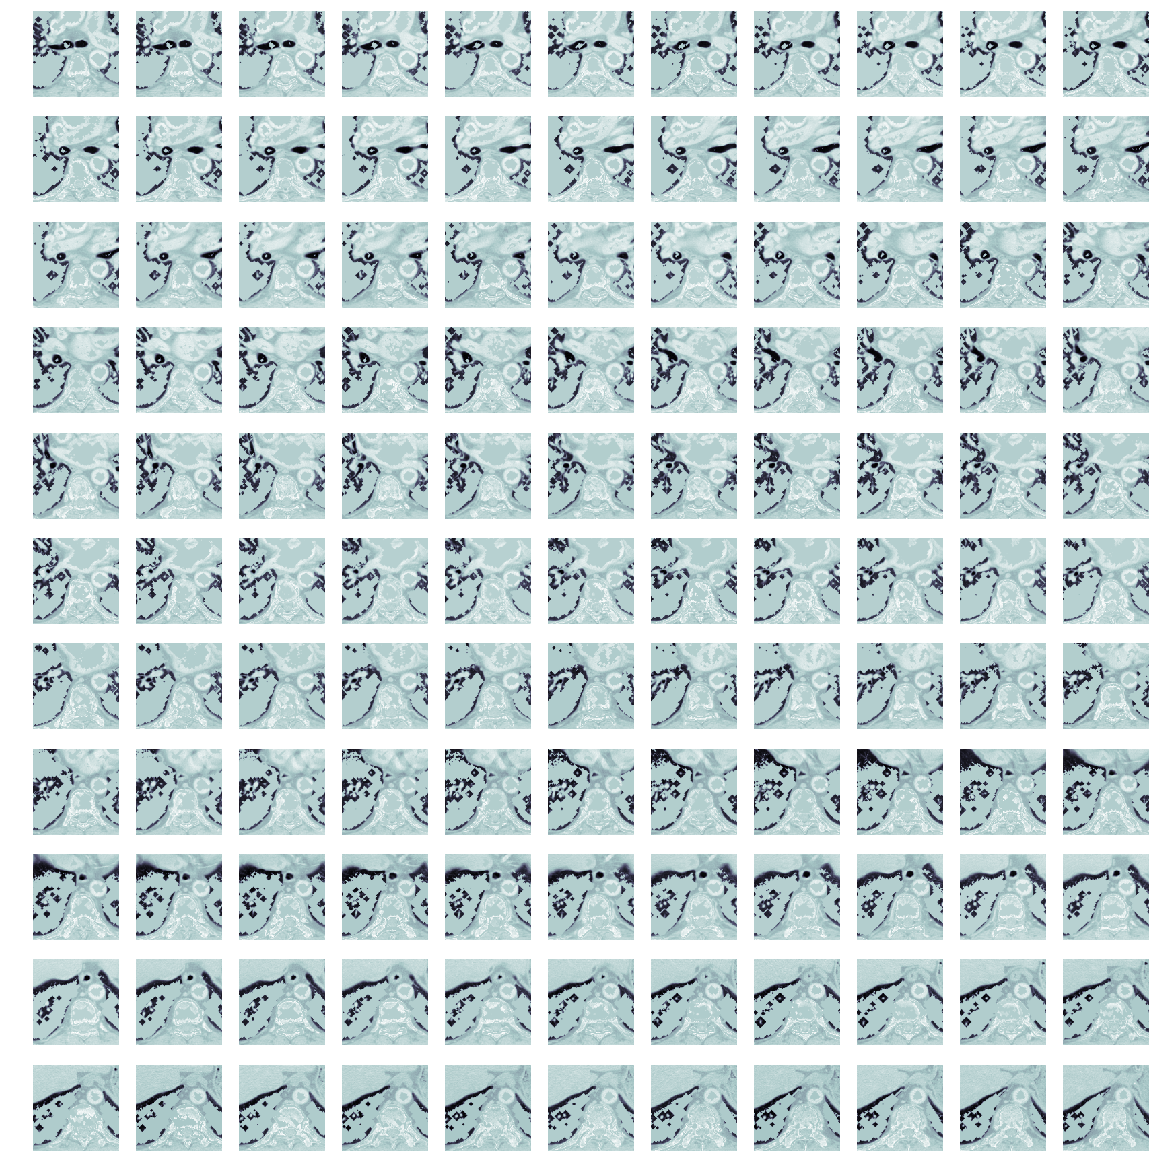

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
f, plots = plt.subplots(11, 11, sharex='all', sharey='all', figsize=(20, 21))
# matplotlib is drunk

for i in range(121):
    plots[i // 11, i % 11].axis('off')
    plots[i // 11, i % 11].imshow(img_array[i], cmap=plt.cm.bone)

In [58]:
img_array = np.load('/Volumes/solo/ali/Data/train_mask/train_full_lung/mask_LKDS-00001_0180_00.npy')
img_array = np.squeeze(img_array)
img_array.shape

(128, 128, 128)

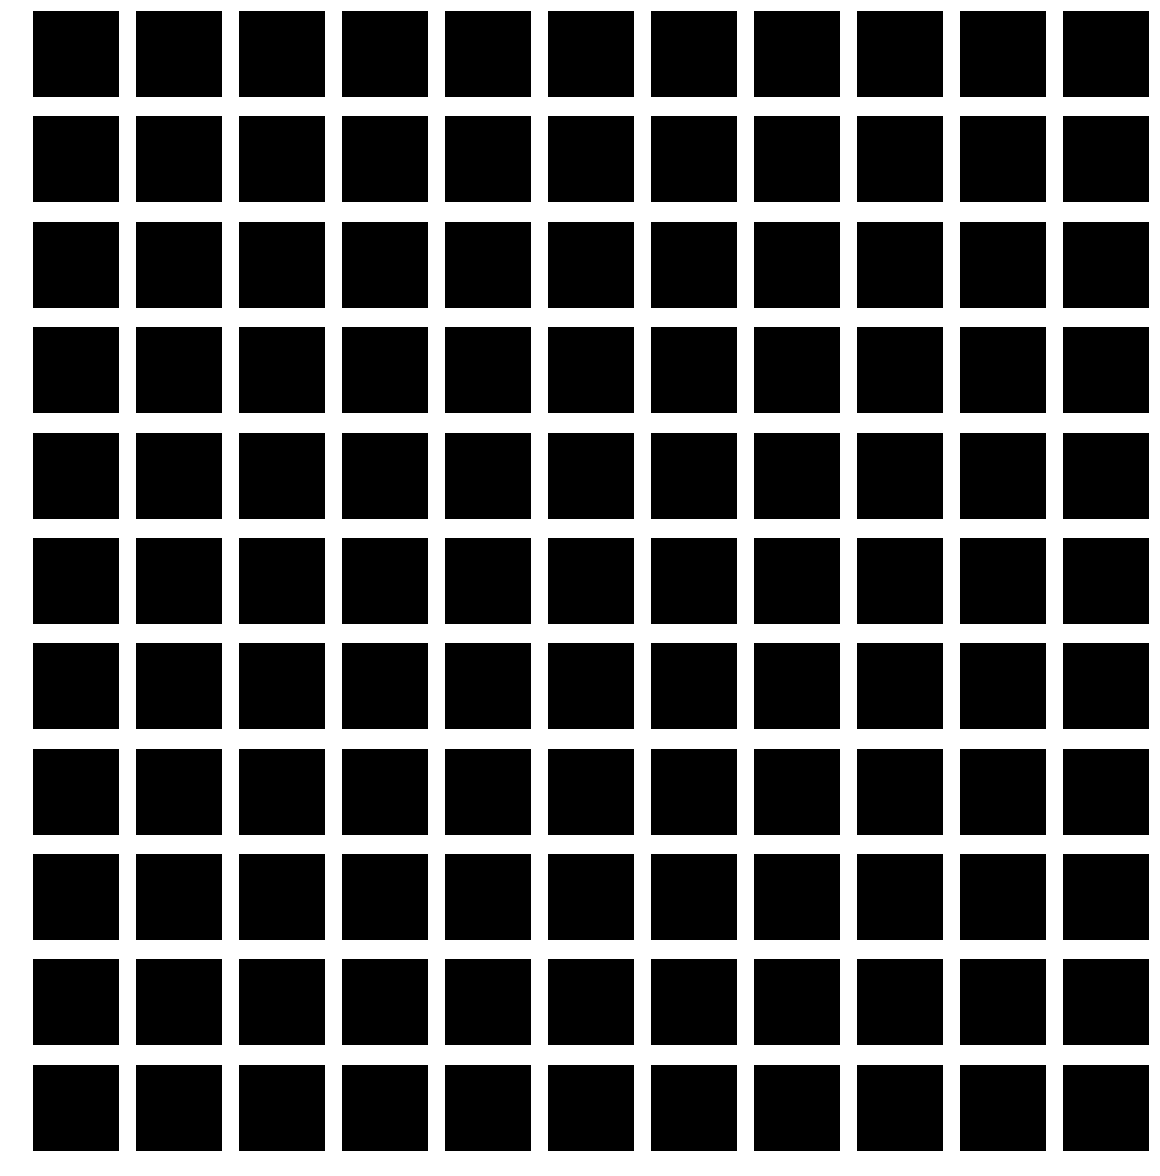

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
f, plots = plt.subplots(11, 11, sharex='all', sharey='all', figsize=(20, 21))
# matplotlib is drunk

for i in range(121):
    plots[i // 11, i % 11].axis('off')
    plots[i // 11, i % 11].imshow(img_array[i], cmap=plt.cm.bone)

In [ ]:
img_array = np.load('/Volumes/solo/ali/Data/train_mask/train_full_lung/LKDS-00001_clean.npy')
img_array = np.squeeze(img_array)

In [ ]:
import torch
from torch.utils.data import Dataset
import os
import time
import collections
import random
#from layers import iou
from scipy.ndimage import zoom
import warnings
from scipy.ndimage.interpolation import rotate

def iou(box0, box1):
    
    r0 = box0[3] / 2
    s0 = box0[:3] - r0
    e0 = box0[:3] + r0

    r1 = box1[3] / 2
    s1 = box1[:3] - r1
    e1 = box1[:3] + r1

    overlap = []
    for i in range(len(s0)):
        overlap.append(max(0, min(e0[i], e1[i]) - max(s0[i], s1[i])))

    intersection = overlap[0] * overlap[1] * overlap[2]
    union = box0[3] * box0[3] * box0[3] + box1[3] * box1[3] * box1[3] - intersection
    return intersection / union

class DataBowl3Detector(Dataset):
    def __init__(self, data_dir, split_path, config, phase = 'train',split_comber=None):
        assert(phase == 'train' or phase == 'val' or phase == 'test')
        self.phase = phase
        self.max_stride = config['max_stride']       
        self.stride = config['stride']       
        sizelim = config['sizelim']/config['reso']
        sizelim2 = config['sizelim2']/config['reso']
        sizelim3 = config['sizelim3']/config['reso']
        self.blacklist = config['blacklist']
        self.isScale = config['aug_scale']
        self.r_rand = config['r_rand_crop']
        self.augtype = config['augtype']
        self.pad_value = config['pad_value']
        self.split_comber = split_comber
        idcs = np.load(split_path)
        if phase!='test':
            idcs = [f for f in idcs if (f not in self.blacklist)]

        self.filenames = [os.path.join(data_dir, '%s_clean.npy' % idx) for idx in idcs]
        self.kagglenames = [f for f in self.filenames if len(f.split('/')[-1].split('_')[0])>20]
        self.lunanames = [f for f in self.filenames if len(f.split('/')[-1].split('_')[0])<20]
        
        labels = []
        
        for idx in idcs:
            l = np.load(os.path.join(data_dir, '%s_label.npy' %idx))
            if np.all(l==0):
                l=np.array([])
            labels.append(l)

        self.sample_bboxes = labels
        if self.phase != 'test':
            self.bboxes = []
            for i, l in enumerate(labels):
                if len(l) > 0 :
                    for t in l:
                        if t[3]>sizelim:
                            self.bboxes.append([np.concatenate([[i],t])])
                        if t[3]>sizelim2:
                            self.bboxes+=[[np.concatenate([[i],t])]]*2
                        if t[3]>sizelim3:
                            self.bboxes+=[[np.concatenate([[i],t])]]*4
            self.bboxes = np.concatenate(self.bboxes,axis = 0)

        self.crop = Crop(config)
        self.label_mapping = LabelMapping(config, self.phase)

    def __getitem__(self, idx,split=None):
        t = time.time()
        np.random.seed(int(str(t%1)[2:7]))#seed according to time

        isRandomImg  = False
        if self.phase !='test':
            if idx>=len(self.bboxes):
                isRandom = True
                idx = idx%len(self.bboxes)
                isRandomImg = np.random.randint(2)
            else:
                isRandom = False
        else:
            isRandom = False
        
        if self.phase != 'test':
            if not isRandomImg:
                bbox = self.bboxes[idx]
                filename = self.filenames[int(bbox[0])]
                imgs = np.load(filename)
                bboxes = self.sample_bboxes[int(bbox[0])]
                isScale = self.augtype['scale'] and (self.phase=='train')
                sample, target, bboxes, coord = self.crop(imgs, bbox[1:], bboxes,isScale,isRandom)
                if self.phase=='train' and not isRandom:
                     sample, target, bboxes, coord = augment(sample, target, bboxes, coord,
                        ifflip = self.augtype['flip'], ifrotate=self.augtype['rotate'], ifswap = self.augtype['swap'])
            else:
                randimid = np.random.randint(len(self.kagglenames))
                filename = self.kagglenames[randimid]
                imgs = np.load(filename)
                bboxes = self.sample_bboxes[randimid]
                isScale = self.augtype['scale'] and (self.phase=='train')
                sample, target, bboxes, coord = self.crop(imgs, [], bboxes,isScale=False,isRand=True)
            label = self.label_mapping(sample.shape[1:], target, bboxes)
            sample = (sample.astype(np.float32)-128)/128
            #if filename in self.kagglenames and self.phase=='train':
            #    label[label==-1]=0
            #return torch.from_numpy(sample), torch.from_numpy(label), coord
            return sample,label
        else:
            imgs = np.load(self.filenames[idx])
            bboxes = self.sample_bboxes[idx]
            nz, nh, nw = imgs.shape[1:]
            pz = int(np.ceil(float(nz) / self.stride)) * self.stride
            ph = int(np.ceil(float(nh) / self.stride)) * self.stride
            pw = int(np.ceil(float(nw) / self.stride)) * self.stride
            imgs = np.pad(imgs, [[0,0],[0, pz - nz], [0, ph - nh], [0, pw - nw]], 'constant',constant_values = self.pad_value)
            
            xx,yy,zz = np.meshgrid(np.linspace(-0.5,0.5,imgs.shape[1]/self.stride),
                                   np.linspace(-0.5,0.5,imgs.shape[2]/self.stride),
                                   np.linspace(-0.5,0.5,imgs.shape[3]/self.stride),indexing ='ij')
            coord = np.concatenate([xx[np.newaxis,...], yy[np.newaxis,...],zz[np.newaxis,:]],0).astype('float32')
            imgs, nzhw = self.split_comber.split(imgs)
            coord2, nzhw2 = self.split_comber.split(coord,
                                                   side_len = self.split_comber.side_len/self.stride,
                                                   max_stride = self.split_comber.max_stride/self.stride,
                                                   margin = self.split_comber.margin/self.stride)
            assert np.all(nzhw==nzhw2)
            imgs = (imgs.astype(np.float32)-128)/128
            return imgs

    def __len__(self):
        if self.phase == 'train':
            return len(self.bboxes)/(1-self.r_rand)
        elif self.phase =='val':
            return len(self.bboxes)
        else:
            return len(self.sample_bboxes)
        
        
def augment(sample, target, bboxes, coord, ifflip = True, ifrotate=True, ifswap = True):
    #                     angle1 = np.random.rand()*180
    if ifrotate:
        validrot = False
        counter = 0
        while not validrot:
            newtarget = np.copy(target)
            angle1 = np.random.rand()*180
            size = np.array(sample.shape[2:4]).astype('float')
            rotmat = np.array([[np.cos(angle1/180*np.pi),-np.sin(angle1/180*np.pi)],[np.sin(angle1/180*np.pi),np.cos(angle1/180*np.pi)]])
            newtarget[1:3] = np.dot(rotmat,target[1:3]-size/2)+size/2
            if np.all(newtarget[:3]>target[3]) and np.all(newtarget[:3]< np.array(sample.shape[1:4])-newtarget[3]):
                validrot = True
                target = newtarget
                sample = rotate(sample,angle1,axes=(2,3),reshape=False)
                coord = rotate(coord,angle1,axes=(2,3),reshape=False)
                for box in bboxes:
                    box[1:3] = np.dot(rotmat,box[1:3]-size/2)+size/2
            else:
                counter += 1
                if counter ==3:
                    break
    if ifswap:
        if sample.shape[1]==sample.shape[2] and sample.shape[1]==sample.shape[3]:
            axisorder = np.random.permutation(3)
            sample = np.transpose(sample,np.concatenate([[0],axisorder+1]))
            coord = np.transpose(coord,np.concatenate([[0],axisorder+1]))
            target[:3] = target[:3][axisorder]
            bboxes[:,:3] = bboxes[:,:3][:,axisorder]
            
    if ifflip:
#         flipid = np.array([np.random.randint(2),np.random.randint(2),np.random.randint(2)])*2-1
        flipid = np.array([1,np.random.randint(2),np.random.randint(2)])*2-1
        sample = np.ascontiguousarray(sample[:,::flipid[0],::flipid[1],::flipid[2]])
        coord = np.ascontiguousarray(coord[:,::flipid[0],::flipid[1],::flipid[2]])
        for ax in range(3):
            if flipid[ax]==-1:
                target[ax] = np.array(sample.shape[ax+1])-target[ax]
                bboxes[:,ax]= np.array(sample.shape[ax+1])-bboxes[:,ax]
    return sample, target, bboxes, coord

In [ ]:
config = {}
config['anchors'] = [ 10.0, 30.0, 60.]
config['chanel'] = 1
config['crop_size'] = [128, 128, 128]
config['stride'] = 4
config['max_stride'] = 16
config['num_neg'] = 800
config['th_neg'] = 0.02
config['th_pos_train'] = 0.5
config['th_pos_val'] = 1
config['num_hard'] = 2
config['bound_size'] = 12
config['reso'] = 1
config['sizelim'] = 5. #mm
config['sizelim2'] = 30
config['sizelim3'] = 40
config['aug_scale'] = True
config['r_rand_crop'] = 0.3
config['pad_value'] = 170
config['augtype'] = {'flip':True,'swap':False,'scale':True,'rotate':False}
config['blacklist'] = []

In [ ]:
np.save('/Volumes/solo/ali/Data/train_mask/train_full_lung/full.npy',np.array(df_node["seriesuid"][0:2],dtype='S32'))

In [ ]:
dataset = DataBowl3Detector(
        '/Volumes/solo/ali/Data/train_mask/train_full_lung/',
        '/Volumes/solo/ali/Data/train_mask/train_full_lung/full.npy',
        config,
        phase = 'train')

In [ ]:
img_array = np.squeeze(dataset[0][0])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
f, plots = plt.subplots(11, 11, sharex='all', sharey='all', figsize=(20, 21))
# matplotlib is drunk

for i in range(121):
    plots[i // 11, i % 11].axis('off')
    plots[i // 11, i % 11].imshow(img_array[i], cmap=plt.cm.bone)

In [ ]:
img_array1 = dataset[0][1]

In [ ]:
img_array1.shape

In [ ]:
img_array1 = img_array1.transpose(3,4,0,1,2)

In [ ]:
img_array1.shape

In [ ]:
img_array1[0][0][0].shape

In [ ]:
f, plots = plt.subplots(5, 5, sharex='all', sharey='all', figsize=(20, 21))
for j in range(25):
    plots[j // 5, j % 5].axis('off')
    plots[j // 5, j % 5].imshow(img_array1[0][0][j])